<a href="https://colab.research.google.com/github/NataliaKurd/transformers_end_assignment/blob/main/transfomers_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfomers: Exploration of memorization in Large Language Models

**Group members:**
- Natalia Kurdanova 1796550
- Jefry el Bhwash 9495495
- Sjardi Djoy Willems 7424442
- Sean van der Tuin 8087287

**Introduction to the notebook**

In order to generate the ouput follow the steps below:
1. Adjust variables in 'block with variables' (it is located after imports)
2. Run: imports, 'block with variables' and download data section
3. Run: loop function

In [2]:
import numpy as np
import pandas as pd
import random
import tqdm
import re
import time

from google.colab import files

from matplotlib import pyplot as plt
from collections import Counter

from transformers import GPTNeoForCausalLM, GPT2Tokenizer, GenerationConfig
import torch

import nltk
from nltk.corpus import stopwords

**Block with variables**

In [19]:
# variables
# p = [50, 100, 150]

colab = True                                                      # if you run locally, set to False

sequence_length = 450                                             # sequence lenght from the name of the file
p = 50                                                            # length of the new ouput generated by the model
prompt_length = sequence_length - p                               # length of the prompt that is provided to the model

number_of_iterations = 1000                                       # number of iterations/ outputs
save_every = 200                                                  # new file is created every n number of iterations

prompts_file_path = 'prompts_' + str(sequence_length) + '.npy'    # name of the prompt file
counts_file_path = 'counts_' + str(sequence_length) + '.npy'      # name of the counts file

model_name = 'EleutherAI/gpt-neo-1.3B'                            # name of the model

## 0. Download data

In this section we download data to the notebook.  
**Action:** add required files to google colab 'files' section. You can find files [here](https://github.com/ethz-spylab/lm_memorization_data)

In [20]:
data_p = np.load(prompts_file_path)
data_c = np.load(counts_file_path)

In [21]:
data_p.shape, data_c.shape

((50000, 450), (50000,))

In [38]:
data_p[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 1. Data exploration

In this section we explore the data: most frequent words, word count, avg length etc.

In [23]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [24]:
vocab = GPT2Tokenizer.from_pretrained(model_name)

In [25]:
decoded_data = []

for ids in tqdm.tqdm(data_prompts):
  decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

100%|██████████| 50000/50000 [05:00<00:00, 166.32it/s]


In [26]:
decoded_data = np.asarray(decoded_data)
decoded_data[199]

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

### 1.1. Data visualization

In [27]:
# top the most frequent sequences
sorted_freq = np.argsort(data_counts)[-50:]

In [29]:
data_counts[sorted_freq]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [30]:
# We have duplicates because we do not have special tokens in the decoded data
print('Number of duplicated sequences: ', len(decoded_data) - len(set(decoded_data)))

Number of duplicated sequences:  49999


In [31]:
# clean the data
cleaned_data = []
regex_string = r'[^\w\s]|[\n]|(\s)(i|1|2|0|if|by|are|at|is|a|an|and|the|of|to|and|in|is|or|for|you|he|she|it|this|that|with|be|on)(\s)'

for sequence in tqdm.tqdm(decoded_data):
  sequence = sequence.lower()
  cleaned_data.append(re.sub(regex_string, ' ', sequence))

100%|██████████| 50000/50000 [00:04<00:00, 11324.62it/s]


In [32]:
cleaned_data = np.asarray(cleaned_data)
cleaned_data[199]

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                  '

In [33]:
df = pd.DataFrame(cleaned_data)
df['Length'] = df[0].apply(len)
df['Word_Count'] = df[0].str.split().apply(len)

In [34]:
df.sort_values(by='Word_Count', ascending=False).head(15)

,0,Length,Word_Count
49999,...,450,0
0,...,450,0
1,...,450,0
2,...,450,0
3,...,450,0
4,...,450,0
5,...,450,0
6,...,450,0
7,...,450,0
8,...,450,0


In [35]:
df.describe()

,Length,Word_Count
count,50000.0,50000.0
mean,450.0,0.0
std,0.0,0.0
min,450.0,0.0
25%,450.0,0.0
50%,450.0,0.0
75%,450.0,0.0
max,450.0,0.0


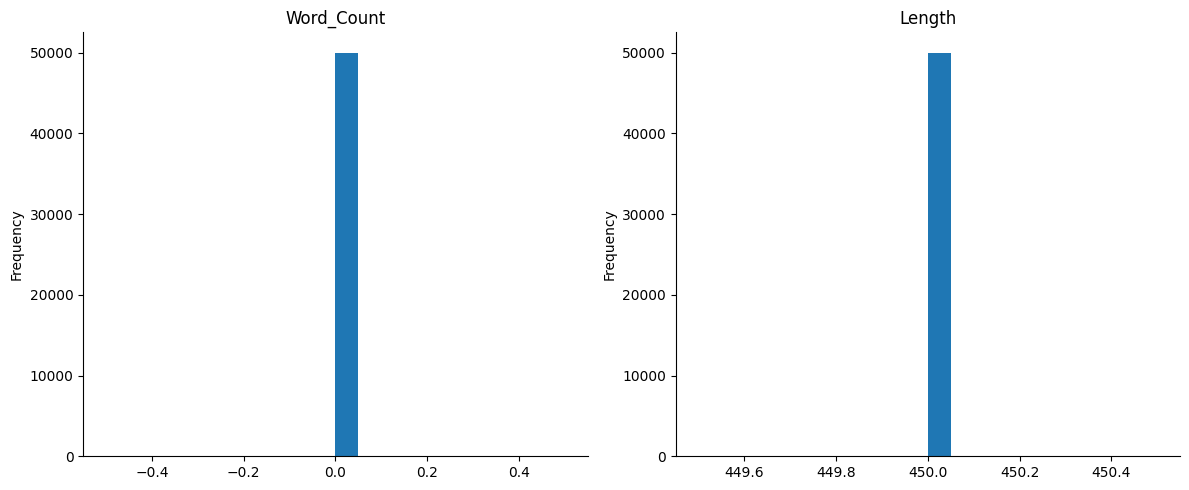

In [36]:
# word count and lenght of the sequences

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

df['Word_Count'].plot(kind='hist', bins=20, title='Word_Count', ax=axes[0])
axes[0].spines[['top', 'right']].set_visible(False)

df['Length'].plot(kind='hist', bins=20, title='Length', ax=axes[1])
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
#plt.savefig('word_count.png')
plt.show()

In [39]:
# most common words

all_words = [word for sentence in df[0] for word in sentence.split() if not word in ['the', '0', 'a', '1', '2', 'i', 's', 'you', 'is']]
word_counts = Counter(all_words)

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words.png')
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in all_words if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('class', 22241), ('li', 20680), ('name', 15033), ('href', 13658), ('span', 12370), ('software', 11036), ('data', 10432), ('html', 10319), ('string', 9598), ('div', 9457), ('license', 9191), ('type', 9078), ('value', 8214), ('use', 7869), ('3', 7714), ('n', 7150), ('â', 7040), ('nbsp', 7001), ('td', 6768), ('com', 6609)]


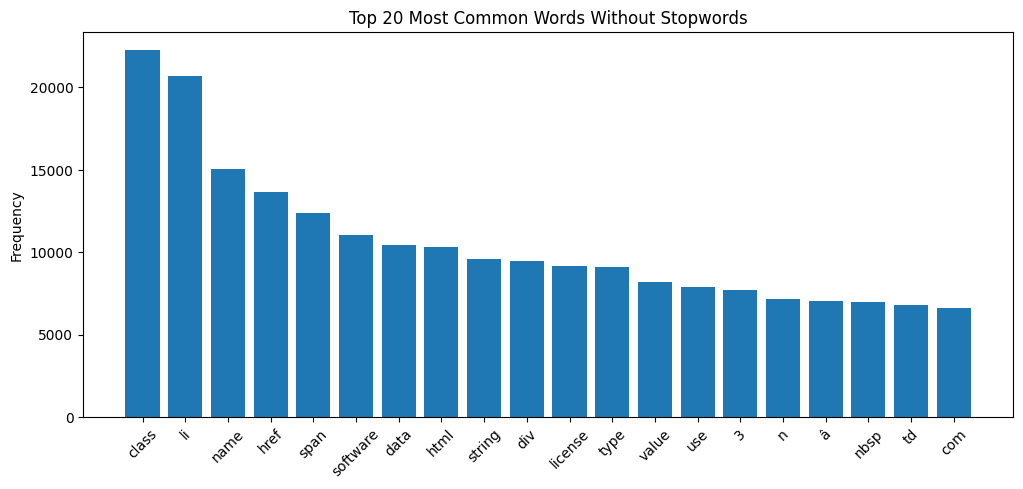

In [ ]:
# without stop words

import matplotlib.pyplot as plt

word_counts = Counter(filtered_sentence)
print(word_counts.most_common(20))

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words Without Stopwords')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words2.png')
plt.show()

In [ ]:
# unique words

unique_words = set(all_words)
print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 158074


## 2. Loading the model and prompt it


Now we will try to promt the model with data from prompts file. As a prompt we will use the first (sequence_length - p) tokens of the sequence. We restrict the model, so, it generates exactly p tokens.

In [10]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [11]:
model = GPTNeoForCausalLM.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

### 2.1 One prompt

In [ ]:
sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))
sequence = sequence.reshape(1, -1)
sequence

<ipython-input-121-495f3da0081d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))


tensor([[  276, 35067,   540,  5317,  5574, 25628,     7,    55,  9514,     8,
          5218,   513,    13,    18,    26,   198,   220,  8925,  1441, 14253,
           276, 35067,   540,    55,     7,    55,  9514,     8,  5218,  1395,
          9783,   198,   220,  8925,  1441, 14253,   276,    55,     7,    55,
          9514,     8,  5218,  1395,  9783,   198,    92,   198,   198, 12417,
          3419,  1391,   198,   220,  2457,  3815,   796,   685, 29710,    16,
         22784,  7308, 29710,    17, 22784,  3834, 29710,    18,  3419, 11208,
           628,   220,  2457,   257,   796,  3815,    58,   600,    13, 29572,
         10786,    15, 11537,    60,   355, 34347,    16,    26,   198,   220,
          2457,   275,   796,  3815,    58,   600,    13, 29572, 10786,    16,
         11537,    60,   355,  7308, 29710,    17,    26,   198,   220,  2457,
           269,   796,  3815,    58,   600,    13, 29572, 10786,    17, 11537,
            60,   355,  3834, 29710,    18,    26,  

In [ ]:
output = model.generate(sequence, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id)
output_d = tokenizer.decode(output[0])

In [ ]:
output_d

"edNullableIntOrDouble(X ignored) => 3.3;\n  dynamic returnBoxedNullableX(X ignored) => X();\n  dynamic returnBoxedX(X ignored) => X();\n}\n\nmain() {\n  final values = [Impl1(), BaseImpl2(), SubImpl3()];\n\n  final a = values[int.parse('0')] as Impl1;\n  final b = values[int.parse('1')] as BaseImpl2;\n  final c = values[int.parse('2')] as SubImpl3;\n  final d = values[int.parse('2')] as Interface;\n\n  a.takePositional(0)\n   .takePositional(1)\n   .takePositional(2)\n   .takePositional(3)\n   .takePositional(4)\n  "

### 2.2 Loop function for the whole dataset

In [12]:
def decode_file(file):

    decoded_data = []

    for ids in tqdm.tqdm(data_prompts):
      decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

    return decoded_data

def generate_output(input_data, n_iter, prompt_length, p):
    """
    """

    result = []

    input_data = input_data.copy()

    for sequence, i in zip(tqdm.tqdm(input_data[:n_iter]), range(1, n_iter + 1)):

      prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)

      output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
        pad_token_id=model.config.eos_token_id)

      output_last_p = output.numpy()[0][prompt_length:]
      sequence_last_p = sequence[prompt_length:]

      memorization = 1 if (output_last_p == sequence_last_p).all() else 0

      result.append([sequence, output.numpy()[0], memorization])

      if i % save_every == 0:
        df = pd.DataFrame(result)
        df.to_csv('output_' + str(sequence_length) + '_' + str(i) + '.csv')
        if colab:
          files.download('output_' + str(sequence_length) + '_' + str(i) + '.csv')

    return result

In [13]:
output = generate_output(data_prompts, number_of_iterations, prompt_length, p)

 40%|████      | 4/10 [00:47<01:08, 11.42s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 90%|█████████ | 9/10 [01:40<00:10, 10.60s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 10/10 [01:50<00:00, 11.10s/it]


In [ ]:
df = pd.DataFrame(output)
df.to_csv('output_' + str(sequence_length) + '_' + 'final' + '.csv')
if colab:
  files.download('output_' + str(sequence_length) + '_' + 'final' + '.csv')

## Appendix 1

In [ ]:
output_encoded = []
output_decoded = []
counter = 0

for sequence in tqdm.tqdm(data_prompts[:number_of_iterations]):

    prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)

    output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
      pad_token_id=model.config.eos_token_id)

    if (output.numpy()[0][prompt_length:] == sequence[prompt_length:]).all():
      counter += 1

    output_d = tokenizer.decode(output[0])
    input_d = tokenizer.decode(sequence)

    print('Counter ', counter)
    print('\n' + 'Input: ' + input_d + '\n' + 'Output: ' + output_d + '\n ---------- \n')

    output_encoded.append(output)
    output_decoded.append(output_d)